## load参数 

In [1]:
import numpy as np
import cv2
import scipy.io as scio

Params=scio.loadmat('workspace.mat')
K = np.array(Params['K'])
K = K.T
distortion=np.array(Params['distortion'])
f = 50

K = np.array([[K[1,1], K[1,0], K[1,2]], [K[0,1], K[0,0], K[0,2]], K[2,:]])

## sift特征匹配

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

imgpath = 'images/'
MIN_MATCH_COUNT = 10

def match_pts(imgname1, imgname2):
    img1 = cv2.imread(imgpath+imgname1, 0)          # queryImage
    img2 = cv2.imread(imgpath+imgname2, 0)        # trainImage

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    pts1 = []
    pts2 = []
    
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            good.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)

    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    # return the np.array type
    return pts1, pts2

## estimate外部参数

In [3]:
from numpy import *
from numpy.linalg import *
import sys
def computePoints(pts, K, f):
    pn = pts.shape[0]
    pts = pts.T
    pts = vstack([pts, ones(pn)])
    
    pcam = zeros((3, pn))
    
    for i in range(pn):
        pcam[:, i] = f * solve(K, pts[:, i])
    
    pcam = pcam.T
    return pcam
    

def findEssential(pcam1, pcam2):
    n1 = pcam1.shape[0]
    n2 = pcam2.shape[0]
    if n1 != n2:
        print('Error: not the same dimensions.')
        sys.exit()
    
    A = zeros((n1, 9))
    for i in range(9):
        A[i,:] = [y*x for x in pcam1[i] for y in pcam2[i]]
    U,S,Vt = svd(A)
    E = Vt[-1, :]
    E = E.reshape(3, 3)
    return E

def findEssentialMat(pts1, pts2, K1, K2):
    F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
    E = K2.T @ F @ K1
    return E

def skew(a):
    return array([[0,-a[2],a[1]],[a[2],0,-a[0]],[-a[1],a[0],0]])

def anti_skew(A):
    if (3,3) != A.shape:
        print('Error: wrong dimension to anti_skew.')
        sys.exit()
        
    if abs(A[0,0])+abs(A[1,1])+abs(A[2,2]) > 0.001:
        return False
    if abs(A[2,1]+A[1,2])/abs(A[2,1]) + abs(A[0,2]+A[2,0])/abs(A[0,2]) + abs(A[1,0]+A[0,1])/abs(A[1,0]) > 0.1:
        return False
    
    x = (A[2,1] - A[1,2]) / 2
    y = (A[0,2] - A[2,0]) / 2
    z = (A[1,0] - A[0,1]) / 2
    return array([x, y, z])

def triangulate(P1, P2, pts1, pts2):
    n1 = pts1.shape[0]
    n2 = pts2.shape[0]
    
    p1 = vstack([ pts1.T, ones(n1) ]).T
    p2 = vstack([ pts2.T, ones(n2) ]).T
    
    P = zeros((n1, 4))
    for i in range(n1):
        cross1 = skew(p1[i])
        cross2 = skew(p2[i])
        Q = vstack([cross1 @ P1, cross2 @ P2])
        U,S,VT = svd(Q)
        z = VT[-1, :]
        P[i, :] = z/z[3]
    return P[:, 0:3]

def computeRT(E):
    U,S,V = svd(E)
    if det(dot(U,V)) < 0:
        V = -V
    E = dot(U,dot(diag([1,1,0]),V))    

    W = array([[0,-1,0],[1,0,0],[0,0,1]])
        
    R21 = dot(U,dot(W,V))
    R22 = dot(U,dot(W.T,V))
    
    T21 = anti_skew(E @ R21.T)
    T22 = anti_skew(E @ R22.T)
    
    R2 = eye(3)
    T2 = zeros(3)
    if R21[0,0] > 0 and R21[1,1] > 0 and R21[2,2] > 0:
        R2 = R21
        T2 = T21
    else:
        R2 = R22
        T2 = T22
        
    if T2[1] > 0:
        T2 = -T2
        
    return R2, T2

def findPose(R, T, K):
    P = K @ vstack([R.T, T]).T
    return P

In [20]:
pts1, pts2 = match_pts('4.jpg', '5.jpg')
pts3, pts4 = match_pts('5.jpg', '6.jpg')

samepts=[]
for x,y in zip(pts2, pts3):
    if x[1] == y[1] and x[0] == y[0]:
        samepts.append(x.tolist())
print(pts2.shape, pts3.shape)
print(len(samepts))
print(samepts)

(1008, 2) (1016, 2)
7
[[401, 835], [483, 1304], [491, 146], [604, 360], [813, 690], [964, 1084], [970, 915]]


In [5]:
print(pts1.shape)

K1 = K; K2 = K
pcam1 = computePoints(pts1, K1, f)
pcam2 = computePoints(pts2, K2, f)
#E = findEssential(pcam1, pcam2)
E = findEssentialMat(pts1, pts2, K1, K2)

R2, T2 = computeRT(E)
print(R2)
print(R2.T @ R2, T2, sep='\n')

(1008, 2)
[[ 0.99933406  0.01154037  0.03461592]
 [-0.0117102   0.99992035  0.00470741]
 [-0.03455884 -0.00510963  0.9993896 ]]
[[ 1.00000000e+00  3.72857127e-16 -1.45716772e-16]
 [ 3.72857127e-16  1.00000000e+00  3.00107161e-16]
 [-1.45716772e-16  3.00107161e-16  1.00000000e+00]]
[-0.99205761 -0.02578893  0.12311223]


## sparse稀疏点云

In [6]:
from numpy import *
from numpy.linalg import *
import sys
def sparse(imgname1, imgname2, K1, K2):
    pts1, pts2 = match_pts(imgname1, imgname2)
    pcam1 = computePoints(pts1, K1, f)
    pcam2 = computePoints(pts2, K2, f)
    
    E = findEssentialMat(pts1, pts2, K1, K2)
    
    R1 = eye(3)
    T1 = zeros(3)
    R2, T2 = computeRT(E)
    
    P1 = findPose(R1, T1, K1)
    P2 = findPose(R2, T2, K2)
    
    X = triangulate(P1, P2, pts1, pts2)
    R = R2
    T = T2
    
    return X, R, T



(1008, 3)
(1016, 3)


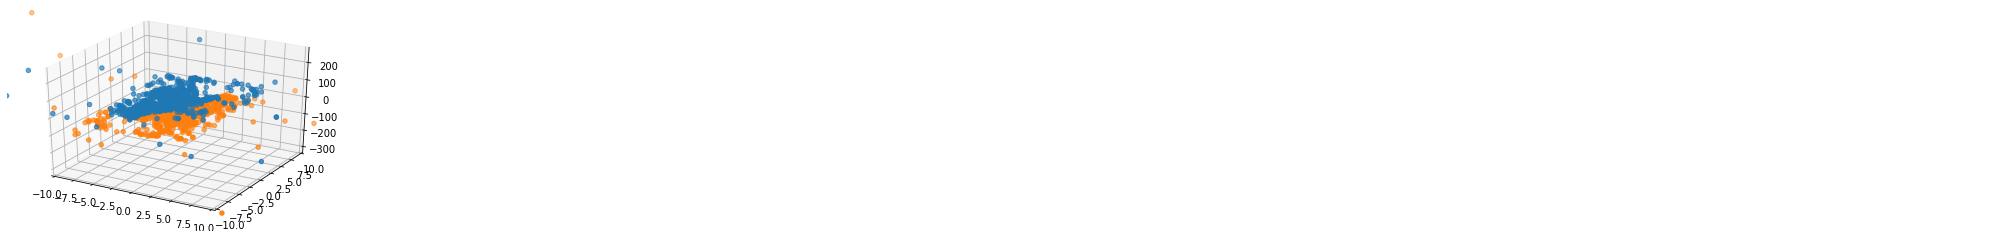

In [40]:
X1, R1, T1 = sparse('4.jpg', '5.jpg', K, K)
X2, R2, T2 = sparse('5.jpg', '6.jpg', K, K)

print(X1.shape)
print(X2.shape)

xn1 = X1.shape[0]
xn2 = X2.shape[0]

X2 = vstack([R1.T, T1]).T @ vstack([X2.T, ones(xn2)])
X2 = X2.T

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d') 

ax.scatter(X1[:,0], X1[:,1], X1[:,2])
ax.scatter(X2[:,0], X2[:,1], X2[:,2])
plt.xlim([-10, 10])
plt.ylim([-10, 10])

plt.show()

In [25]:
pts1, pts2 = match_pts('4.jpg', '5.jpg')
pts3, pts4 = match_pts('5.jpg', '6.jpg')

pcam1 = computePoints(pts1, K1, f)
pcam2 = computePoints(pts2, K2, f)
pcam4 = computePoints(pts4, K2, f)

n1 = pts2.shape[0]
n2 = pts3.shape[0]
print(n1, n2)

1008 1016


In [35]:
sid = []
spts = []
for i in range(n1):
    for j in range(n2):
        if pts2[i][0] == pts3[j][0] and pts2[i][1] == pts3[j][1]:
            sid.append((i, j))
            spts.append(pts2[i])
            
yn = len(sid)
Y1 = zeros((yn, 3))
Y2 = zeros((yn, 3))
for i in range(yn):
    Y1[i, :] = R1.T @ (X1[sid[i][0]] - T1)

    
for i in range(yn):
    Y2[i,:] = X2[sid[i][1]]
    
scale = 0
for i in range(yn):
    scale += Y1[i][-1] / Y2[i][-1]
scale = scale / yn
print(scale)

-0.8729569265342363


(1008, 3)
(1016, 3)


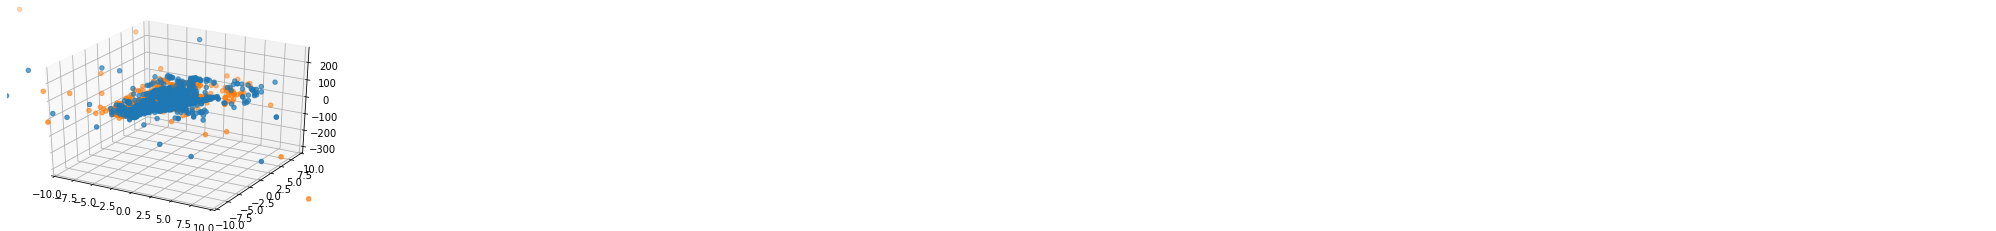

In [41]:
def multi_sparse(pts1, pts2, scale, K1, K2):
    E = findEssentialMat(pts1, pts2, K1, K2)
    
    R1 = eye(3)
    T1 = zeros(3)
    R2, T2 = computeRT(E)
    T2 = scale * T2
    
    P1 = findPose(R1, T1, K1)
    P2 = findPose(R2, T2, K2)
    
    X = triangulate(P1, P2, pts1, pts2)
    R = R2
    T = T2
    
    return X, R, T

X1, R1, T1 = multi_sparse(pts1, pts2, 1, K, K)
X2, R2, T2 = multi_sparse(pts3, pts4, scale, K, K)

print(X1.shape)
print(X2.shape)

X2 = vstack([R1.T, T1]).T @ vstack([X2.T, ones(xn2)])
X2 = X2.T 

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d') 

ax.scatter(X1[:,0], X1[:,1], X1[:,2])
ax.scatter(X2[:,0], X2[:,1], X2[:,2])
plt.xlim([-10, 10])
plt.ylim([-10, 10])

plt.show()